## Set up data

In [1]:
import numpy as np
import pandas as pd

In [2]:
import stan

In [3]:
import nest_asyncio
nest_asyncio.apply()

In [4]:
bpath = '~/source/rethinking/'

In [5]:
df = pd.read_csv(bpath + 'data/Howell1.csv', sep=';')

In [6]:
df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


## Exercise 1

In [7]:
df_a = df[df['age'] >= 18].copy()

In [8]:
xbar = np.mean(df_a['weight'])

In [9]:
df_a['centred_weight'] = df_a['weight'] - xbar

In [10]:
model_code = """
data {
  int<lower=0> N;
  vector[N] x;
  vector[N] y;
}
parameters {
  real alpha;
  real beta;
  real<lower=0, upper=50> sigma;
}
model {
  y ~ normal(alpha + beta * x, sigma);
  alpha ~ normal(178, 20);
  beta ~ normal(0, 1);
}
"""

In [11]:
model_data = {"N": len(df_a),
                "x": df_a['weight'].to_numpy(),
                "y": df_a['height'].to_numpy()}


In [12]:
posterior = stan.build(model_code, data=model_data, random_seed=123)

Building...

Building: found in cache, done.Messages from stanc:
  The parameter sigma has no priors.
  Your Stan program has a parameter sigma with a lower and upper bound in its
  declaration. These hard constraints are not recommended, for two reasons:
  (a) Except when there are logical or physical constraints, it is very
  unusual for you to be sure that a parameter will fall inside a specified
  range, and (b) The infinite gradient induced by a hard constraint can cause
  difficulties for Stan's sampling algorithm. As a consequence, we recommend
  soft constraints rather than hard constraints; for example, instead of
  constraining an elasticity parameter to fall between 0, and 1, leave it
  unconstrained and give it a normal(0.5,0.5) prior distribution.
Warning at '/tmp/httpstan_y69zig2p/model_jxl2kd43.stan', line 14, column 17 to column 20:
  Argument 178 suggests there may be parameters that are not unit scale;
  consider rescaling with a multiplier (see manual section 22.12).

In [13]:
fit = posterior.sample(num_chains=4, num_samples=1000)

Sampling:   0%
Sampling:   1% (100/8000)
Sampling:   2% (200/8000)
Sampling:   3% (201/8000)
Sampling:   4% (301/8000)
Sampling:   5% (401/8000)
Sampling:   5% (401/8000)
Sampling:   5% (401/8000)
Sampling:   8% (601/8000)
Sampling:  11% (901/8000)
Sampling:  15% (1201/8000)
Sampling:  18% (1400/8000)
Sampling:  20% (1600/8000)
Sampling:  22% (1800/8000)
Sampling:  25% (2000/8000)
Sampling:  30% (2400/8000)
Sampling:  32% (2600/8000)
Sampling:  36% (2901/8000)
Sampling:  54% (4301/8000)
Sampling:  71% (5701/8000)
Sampling:  88% (7001/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000773 seconds
  1000 transitions using 10 leapfrog steps per transition would take 7.73 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000297 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.97 seconds.
  Adjust your expectations accordingl

In [14]:
def predict_height(weight, pi):
    height_preds = fit['alpha'] + fit['beta'] * weight + np.random.normal(0, fit['sigma'])
    mean_height = np.mean(height_preds)
    height_interval = np.quantile(height_preds, [(1-pi)/2, 1-(1-pi)/2])

    return mean_height, height_interval[0], height_interval[1]

In [15]:
results = pd.DataFrame()

In [16]:
results['weight'] = [45, 40, 65, 31, 53]

In [17]:
results['expected'], results['lower'], results['upper'] = \
    zip(*results['weight'].map(lambda x: predict_height(x, 0.89)))

In [18]:
results

,weight,expected,lower,upper
0,45,154.487588,146.350543,162.584171
1,40,150.112412,141.932700,158.366520
2,65,172.369219,164.039809,180.854214
3,31,142.146121,133.994005,150.262091
4,53,161.724259,153.479339,169.970610


## Exercise 2

In [19]:
import math

In [20]:
df['log_weight'] = df['weight'].apply(math.log)

In [21]:
df['centred_log_weight'] = df['log_weight'] - np.mean(df['log_weight'])

In [22]:
model_code = """
data {
  int<lower=0> N;
  vector[N] x;
  vector[N] y;
}
parameters {
  real alpha;
  real beta;
  real<lower=0, upper=50> sigma;
}
model {
  y ~ normal(alpha + beta * x, sigma);
  alpha ~ normal(178, 20);
  beta ~ lognormal(0, 1);
}
"""

In [23]:
model_data = {"N": len(df),
                "x": df['centred_log_weight'].to_numpy(),
                "y": df['height'].to_numpy()}

In [24]:
posterior = stan.build(model_code, data=model_data, random_seed=321)

Building...

Building: found in cache, done.Messages from stanc:
  The parameter sigma has no priors.
  Your Stan program has a parameter sigma with a lower and upper bound in its
  declaration. These hard constraints are not recommended, for two reasons:
  (a) Except when there are logical or physical constraints, it is very
  unusual for you to be sure that a parameter will fall inside a specified
  range, and (b) The infinite gradient induced by a hard constraint can cause
  difficulties for Stan's sampling algorithm. As a consequence, we recommend
  soft constraints rather than hard constraints; for example, instead of
  constraining an elasticity parameter to fall between 0, and 1, leave it
  unconstrained and give it a normal(0.5,0.5) prior distribution.
Warning at '/tmp/httpstan_plbqzaij/model_53lpcodd.stan', line 14, column 17 to column 20:
  Argument 178 suggests there may be parameters that are not unit scale;
  consider rescaling with a multiplier (see manual section 22.12).

In [25]:
fit = posterior.sample(num_chains=4, num_samples=1000)

Sampling:   0%
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   9% (700/8000)
Sampling:  12% (1000/8000)
Sampling:  32% (2600/8000)
Sampling:  56% (4500/8000)
Sampling:  79% (6300/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000369 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.69 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000487 seconds
  1000 transitions using 10 leapfrog steps per transition would take 4.87 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00076 seconds
  1000 transitions using 10 leapfrog steps per transition would take 7.6 seconds.
  Adjust your expectations accordingly!
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: lognormal_lpdf: Random variable is -0.0724811, but must be nonnegative! (in '/tmp/httpstan_0a5k3shz/m

In [26]:
preds = pd.DataFrame()

In [27]:
preds['seq_val'] = np.arange(1, 61, 1)

In [28]:
preds['log_seq_val'] = preds['seq_val'].apply(math.log)

In [29]:
preds['model_seq_val'] = preds['log_seq_val'] - np.mean(df['log_weight'])

In [30]:
preds['expected'], preds['lower'], preds['upper'] = \
    zip(*preds['model_seq_val'].map(lambda x: predict_height(x, 0.99)))

In [31]:
preds.tail()

,seq_val,log_seq_val,model_seq_val,expected,lower,upper
55,56,4.025352,0.583022,165.727230,152.009903,178.881319
56,57,4.043051,0.600721,166.467097,152.578107,179.857461
57,58,4.060443,0.618113,167.349980,154.028648,180.539543
58,59,4.077537,0.635208,168.263196,155.374229,181.300038
59,60,4.094345,0.652015,168.884613,156.753587,182.098112


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

(45.0, 185.0)

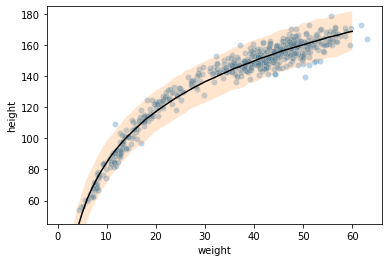

In [33]:
fig, ax = plt.subplots()
sns.scatterplot(x=df['weight'],y=df['height'], ax=ax, alpha=0.3)
sns.lineplot(x=preds['seq_val'],y=preds['expected'], color = 'black')
ax.fill_between(preds['seq_val'], preds['lower'], preds['upper'], alpha=0.2)
plt.ylim(45, 185)

## Exercise 3

In [34]:
model_code = """
data {
  int<lower=0> N;
  vector[N] x;
  vector[N] x_sq;
  vector[N] y;
}
parameters {
  real alpha;
  real beta1;
  real beta2;
  real<lower=0, upper=50> sigma;
}
model {
  y ~ normal(alpha + beta1 * x + beta2 * x_sq, sigma);
  alpha ~ normal(178, 20);
  beta1 ~ lognormal(0, 1);
  beta2 ~ normal(0,1);
}
generated quantities {
  real alpha_sim = normal_rng(178,20);
  real<lower=0> beta1_sim = lognormal_rng(0,1);
  real beta2_sim = normal_rng(0,1);
}
"""

In [35]:
df['weight_s'] = (df['weight'] - np.mean(df['weight']))/np.std(df['weight'])

In [36]:
df['weight_s2'] = df['weight_s']**2

In [37]:
model_data = {"N": len(df),
                "x": df['weight_s'].to_numpy(),
                "x_sq": df['weight_s2'].to_numpy(),
                "y": df['height'].to_numpy()}

In [38]:
posterior = stan.build(model_code, data=model_data, random_seed=323)

Building...

Building: found in cache, done.Messages from stanc:
  The parameter sigma has no priors.
  Your Stan program has a parameter sigma with a lower and upper bound in its
  declaration. These hard constraints are not recommended, for two reasons:
  (a) Except when there are logical or physical constraints, it is very
  unusual for you to be sure that a parameter will fall inside a specified
  range, and (b) The infinite gradient induced by a hard constraint can cause
  difficulties for Stan's sampling algorithm. As a consequence, we recommend
  soft constraints rather than hard constraints; for example, instead of
  constraining an elasticity parameter to fall between 0, and 1, leave it
  unconstrained and give it a normal(0.5,0.5) prior distribution.
Warning at '/tmp/httpstan_fetp6h2n/model_fcem2ykf.stan', line 16, column 17 to column 20:
  Argument 178 suggests there may be parameters that are not unit scale;
  consider rescaling with a multiplier (see manual section 22.12).

In [39]:
fit = posterior.sample(num_chains=4, num_samples=1000)

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   1% (102/8000)
Sampling:   3% (202/8000)
Sampling:   8% (601/8000)
Sampling:  11% (900/8000)
Sampling:  15% (1200/8000)
Sampling:  18% (1400/8000)
Sampling:  22% (1800/8000)
Sampling:  28% (2200/8000)
Sampling:  34% (2700/8000)
Sampling:  40% (3200/8000)
Sampling:  55% (4400/8000)
Sampling:  71% (5700/8000)
Sampling:  85% (6800/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000339 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.39 seconds.
  Adjust your expectations accordingly!
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: lognormal_lpdf: Random variable is -0.418137, but must be nonnegative! (in '/tmp/httpstan_wl0i6u2j/model_fcem2ykf.stan', line 17, column 2 to column 26)
  Gradient evaluation took 0.000448 seconds
  1000 transitions using 10

In [40]:
print(np.quantile(fit['alpha_sim'], [0.05, 0.95]))
print(np.mean(fit['alpha_sim']))
print(np.quantile(fit['beta1_sim'], [0.05, 0.95]))
print(np.mean(fit['beta1_sim']))
print(np.quantile(fit['beta2_sim'], [0.05, 0.95]))
print(np.mean(fit['beta2_sim']))

[145.495678   211.09660083]
178.20140109452424
[0.19549271 5.1243696 ]
1.6454046851125543
[-1.62420256  1.63746346]
-0.0022098310649775045


In [41]:
w_seq = np.linspace(np.min(df['weight_s']), np.max(df['weight_s']), 50)

In [42]:
w2_seq = w_seq**2

In [43]:
sim_df = pd.DataFrame({"w_seq": w_seq,
                        "w2_seq": w2_seq})

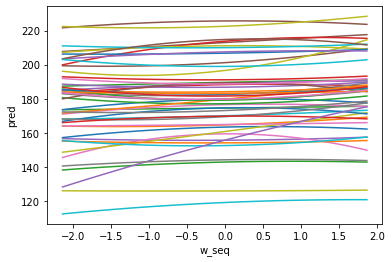

In [44]:
fig, ax = plt.subplots()
for plot_no in range(0,50):
    sim_df['pred'] = fit['alpha_sim'][0][plot_no] + fit['beta1_sim'][0][plot_no]*sim_df['w_seq'] + fit['beta2_sim'][0][plot_no]*sim_df['w2_seq']
    sns.lineplot(x=sim_df['w_seq'],y=sim_df['pred'], ax=ax)